# Diversity

For this experiment, we will want to find multiple different levels with the same difficulty.

In [1]:
import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU, functional as F
from torch.optim import Adam

from evaluators import DirectEvaluator
from shared_parameters import *
from utils import MLP

torch.set_printoptions(linewidth=120, sci_mode=False)

Let's define our components.

Here our generator NN will define the *offset* from the point in space, that is
also fed in as an input to the generator.

In [5]:
class Generator(MLP):
    def __init__(self, embedding_size: int, hidden=None, activation=None):
        super().__init__(1 + embedding_size, 1, hidden=hidden, activation=activation)

        # We then need to initialize the network to output zero offsets initially
        # We'll do that by simply zeroing the weights
        for p in self.parameters():
            p.data.mul_(0.1)

    def forward(self, x):
        # Generate the offset
        offset = super().forward(x)
        # Add to the starting point, also return the generated offset
        return x[:, 1:] + offset, offset


# We'll define simple remapping function that will map out outputs from
def remap(x):
    return x * (enemy_x_max - enemy_x_min) + enemy_x_min

Preview of the embedding space and difficulties

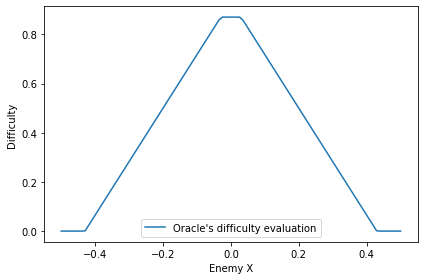

In [6]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
enemy_x = np.linspace(enemy_x_min, enemy_x_max, 100)
evaluation = oracle(enemy_x)

axs = plt.subplot()

axs.plot(enemy_x, evaluation)
axs.set_xlabel("Enemy X")
axs.set_ylabel("Difficulty")
axs.legend(["Oracle's difficulty evaluation"])
plt.tight_layout()

plt.show()

We see that for the same difficulty, there exist several levels, that have the same difficulty.
However, with the way we've set up our generators, they can only output a single level for the given difficulty.

Now let's give the generator two inputs: the input difficulty $d_{in}$, as well the seed $\epsilon$

    Let's try with the simultaneous learning first

It.: 3164, (G) 0.03831 (diff) 1.00000
Parameters:
tensor([[-0.0064,  0.1162],
        [-0.3879,  0.4913],
        [ 0.1542, -1.1884],
        [ 0.0924, -0.1339],
        [ 0.1029,  0.7647],
        [ 0.7913,  0.2300],
        [ 0.4990, -1.3438],
        [-0.0459, -1.2768]])
tensor([-0.2253, -0.0062,  0.4999, -0.3634, -0.1259, -0.1267,  0.2251,  0.7244])
tensor([[-0.1471, -1.0216, -0.3698,  0.5719, -0.3443, -0.0055, -1.1297,  0.8301],
        [ 0.0713, -1.0413, -0.9779,  1.0069,  0.0422, -0.2855, -1.0977,  1.0793],
        [-0.0225,  0.2263, -3.2618,  0.1226,  0.6739,  0.0490, -3.3166,  2.4982],
        [-0.0885, -0.9983,  0.4123,  0.2982, -0.5745,  0.1777,  0.6835, -0.0138],
        [-0.0342, -0.5483, -0.8113,  0.1339,  0.0786,  0.6369, -1.3635,  1.3568],
        [-0.1491, -0.8549, -0.3496,  0.3434, -0.1140,  0.1978, -0.1976,  0.3057],
        [-0.0839, -1.1053,  0.1266,  0.3458, -0.0624, -0.2130,  0.1499,  0.1679],
        [-0.0245, -0.2150, -0.6667,  0.1713,  0.0737,  0.2176, -1.2518

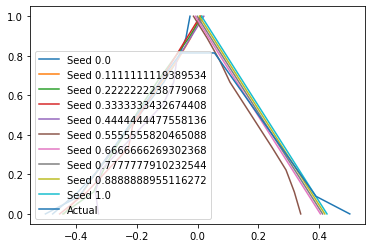

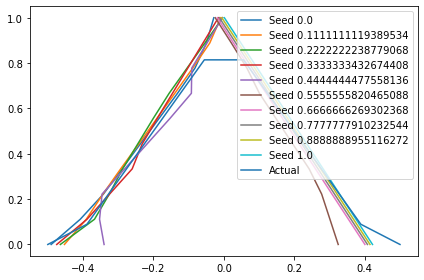

In [10]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
generator = Generator(embedding_size=1, hidden=[8, 8], activation=LeakyReLU())
optim_generator = Adam(generator.parameters(), lr=0.01)

num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(0, 1, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds)

iteration = 0
loss_evaluator = float("inf")


def iterate(verbose=False):
    global dataset, iteration
    indices = torch.randperm(dataset.shape[0])[:15]
    inputs = dataset[indices]

    states, offsets = generator(inputs)
    d_out = oracle(remap(states))

    d_in = inputs[:, :1]
    _seeds = inputs[:, 1:]

    difference = torch.ones([1])
    loss_generator = F.l1_loss(d_in, d_out)

    # Also minimize offsets (important!)
    offsets_size = torch.norm(offsets, dim=-1, keepdim=True)
    loss = loss_generator + offsets_size.mean()

    # Update the generator
    optim_generator.zero_grad()
    loss.backward()
    optim_generator.step()

    iteration += 1

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"(G) {loss_generator.item():.5f} "
              f"(diff) {difference.item():.5f}")

        print("Parameters:")
        for p in generator.parameters():
            print(p.data)

        difficulties = torch.linspace(0, 1, 10)
        seeds = torch.linspace(0, 1, 10)
        dataset = torch.cartesian_prod(difficulties, seeds)

        generated_states = generator(dataset)[0].detach()

        d_out = oracle(remap(generated_states))

        collected = torch.hstack((dataset, generated_states, d_out))

        fix, ax = plt.subplots()

        for i in range(seeds.shape[0]):
            selected = collected[i::difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            # print(selected)
            # print()
            ax.plot(remap(xs), ds)

        ax.plot(remap(seeds), oracle(remap(seeds)))

        ax.legend([*[f"Seed {seed}" for seed in seeds], "Actual"])
        plt.tight_layout()

        plt.show()


iterate()

try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

It.: 10203, (G) 0.05021 (diff) 1.00000
Parameters:
tensor([[ 0.3017, -0.1049],
        [ 0.0833,  0.3347],
        [ 0.0140,  0.1746],
        [-0.0026, -0.5636],
        [-0.1228, -0.2770],
        [ 0.2333, -0.1450],
        [-0.0018, -0.3681],
        [ 0.1202, -0.7357]])
tensor([ 0.1041, -0.2185,  0.1127,  0.3143, -0.0411,  0.1440,  0.2060,  0.2660])
tensor([[    -0.1368,     -0.1386,      0.0782,     -0.3379,     -0.1284,     -0.1233,     -0.2185,      0.5573],
        [     0.0005,     -0.6620,      0.1429,     -0.7169,     -0.1771,     -0.0084,     -0.3358,      0.7901],
        [     0.1259,      0.7404,      0.0494,      0.8028,     -0.0139,      0.0907,      0.4257,     -1.2665],
        [     0.0105,     -0.6784,      0.1463,     -0.5967,     -0.1243,      0.0435,     -0.3676,      1.0873],
        [     0.2514,      0.8426,      0.0228,      0.8995,     -0.0233,      0.1920,      0.4071,     -1.3621],
        [     0.0469,     -0.8553,      0.1309,     -0.7945,     -0.1509,

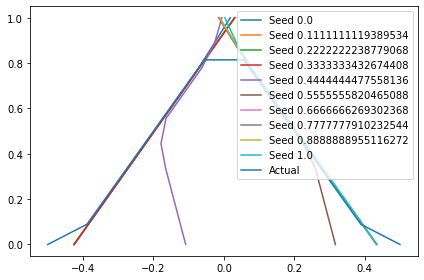

In [49]:
try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)